# Exploratody data analysis

In [1]:
import os 
import sys
import glob
import pickle
import pyprind
import pandas as pd
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

import warnings
warnings.filterwarnings('ignore')

import utils
import data_prep as prep
import train_select as ts

In [2]:
random_state = 42

In [3]:
npi = prep.prepare_npi(prep.npi_url, dropna=True, add_new_features=True, verbose=True)

INFO Data set PartD_Prescriber_PUF_NPI_15.zip
INFO from url: http://download.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Downloads/PartD_Prescriber_PUF_NPI_15.zip
INFO successfully downloaded and uncompressed
INFO Data cleaning completed
INFO New features are added


# Descriptive statistics
#### 1. op_prescriber

In [4]:
npi.op_prescriber.value_counts() 

True     438183
False    192807
Name: op_prescriber, dtype: int64

#### 2. Average days op_prescribed if  opioid was prescribed

In [5]:
npi['avg_op_day_supply'].describe()

count    630990.000000
mean         33.536462
std          52.416996
min           0.000000
25%           0.000000
50%           6.406250
75%          51.730509
max         695.891566
Name: avg_op_day_supply, dtype: float64

#### 3. op_longer

In [6]:
npi.op_longer.value_counts()

False    533997
True      96993
Name: op_longer, dtype: int64

In [4]:
ntl, drug_name_dict = prep.get_drug_name_dict(threshold=500)
non_op_names, op_names = prep.get_drug_names(ntl, drug_name_dict, 
                                        n_other_drugs=prep.n_other_drugs, 
                                        random_state=random_state)

INFO Data set PartD_Prescriber_PUF_Drug_Ntl_15.zip
INFO from url: http://download.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Downloads/PartD_Prescriber_PUF_Drug_Ntl_15.zip
INFO successfully downloaded and uncompressed


In [5]:
for k in drug_name_dict.keys():
    print("{}: {}".format(k, len(drug_name_dict[k])))

Antibiotic Drug Flag: 78
High Risk Medication (HRM) Drug Flag: 68
others: 951
Opioid Drug Flag: 29
Antipsychotic Drug Flag: 28


## Make small dataset for EDA

In [7]:
drugs = prep.download_drugs()

INFO Data set PartD_Prescriber_PUF_NPI_DRUG_15.zip
INFO from url: http://download.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Downloads/PartD_Prescriber_PUF_NPI_DRUG_15.zip
INFO successfully downloaded and uncompressed


We'll use batches 0 through 5, except batch 0 and 2 (which are included in the test set), for exploratory data analysis.

In [17]:
chunk_size = prep.chunk_size  # 100,000
eda_df = None
batch_to_pass = [0, 2]
for i in range(5):
    if i in batch_to_pass: 
        pass
    
    else:
        tmp_df = prep.clean_drug_chunks(drugs, npi, non_op_names, op_names, scale=False, chunk_size=chunk_size)
        if eda_df is None:
            eda_df = tmp_df
        else:
            eda_df = pd.concat([eda_df, tmp_df])

In [18]:
print(eda_df.shape)
#list(eda_df.columns)

(17703, 455)


In [19]:
with open('dataset/eda.pickle', 'wb') as f:
    pickle.dump(eda_df, f)
    f.close()

# Specialty vs avg day of opioid supply

In [23]:
npi_op = npi.loc[:, ['op_day_supply', 'avg_op_day_supply']]
df = eda_df.join(npi_op, how='inner')

In [24]:
tmp = df['avg_op_day_supply'].groupby(df['specialty']).describe().unstack()
misc = tmp.loc[tmp['count'] < 10, :].index
df = df.loc[~df['specialty'].isin(misc), :]
grouped_spec = df['avg_op_day_supply'].groupby(df['specialty'])
grouped_spec_mean = grouped_spec.mean().sort_values(ascending=False)
top20 = grouped_spec_mean.index[:20]
top40 = grouped_spec_mean.index[:40]
top63 = grouped_spec_mean.index[:63]

In [64]:
total_spec = df['op_day_supply'].groupby(df['specialty']).sum().sort_values(ascending=False)
#total_spec / total_spec.sum()

#### pandas 

In [177]:
#eda_df.boxplot('avg_op_day_supply', by='specialty')

#### plotly

In [178]:
import plotly.plotly as py
import plotly.graph_objs as go
    
data = []
for name, group in grouped_spec:
    if name in top20:
        trace = go.Box(x=group, name=name)
        data.append(trace)
    
#py.iplot(data)

#### seaborn

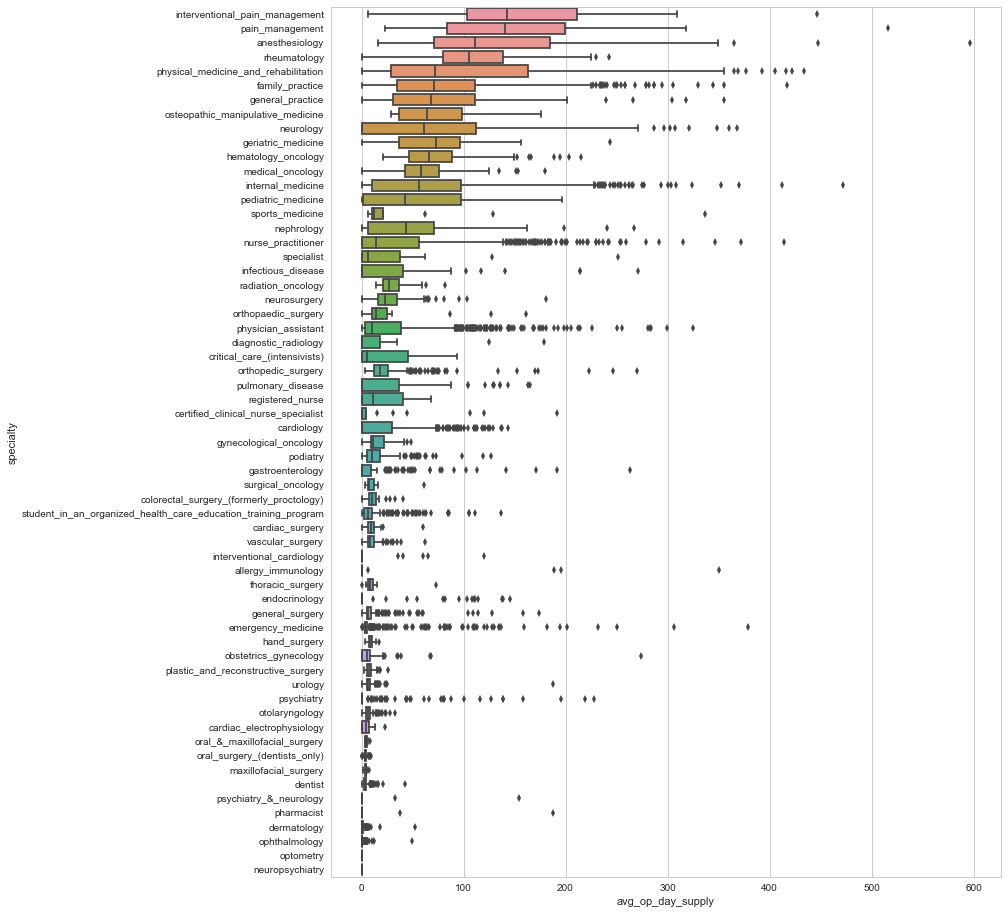

In [26]:
sns.set(style='whitegrid', rc={"figure.figsize": (12, 16)})
df_small = df.loc[:, ['specialty', 'avg_op_day_supply']]
df_small = df_small.loc[df['specialty'].isin(top63), :]
sns.boxplot(data=df_small, y='specialty', x='avg_op_day_supply', order=top63)
plt.show()

In [27]:
tmp = df_small.groupby(df_small['specialty']).describe().unstack()
tmp.loc[top40, ]

avg_op_day_supply  \
                                                               count   
specialty                                                              
interventional_pain_management                                  52.0   
pain_management                                                 63.0   
anesthesiology                                                 100.0   
rheumatology                                                   142.0   
physical_medicine_and_rehabilitation                           180.0   
family_practice                                               2490.0   
general_practice                                               154.0   
osteopathic_manipulative_medicine                               14.0   
neurology                                                      231.0   
geriatric_medicine                                              57.0   
hematology_oncology                                            248.0   
medical_oncology                                                97.0   
internal_medicine                                             3390.0   
pediatric_medicine                                              31.0   
sports_medicine                                                 13.0   
nephrology                                                     208.0   
nurse_practitioner                                            1683.0   
specialist                                                      18.0   
infectious_disease                                              50.0   
radiation_oncology                                              44.0   
neurosurgery                                                   107.0   
orthopaedic_surgery                                             23.0   
physician_assistant                                           1325.0   
diagnostic_radiology                                            17.0   
critical_care_(intensivists)                                    19.0   
orthopedic_surgery                                             475.0   
pulmonary_disease                                              156.0   
registered_nurse                                                10.0   
certified_clinical_nurse_specialist                             25.0   
cardiology                                                     359.0   
gynecological_oncology                                          20.0   
podiatry                                                       229.0   
gastroenterology                                               150.0   
surgical_oncology                                               11.0   
colorectal_surgery_(formerly_proctology)                        32.0   
student_in_an_organized_health_care_education_t...             279.0   
cardiac_surgery                                                 23.0   
vascular_surgery                                                78.0   
interventional_cardiology                                       29.0   
allergy_immunology                                              69.0   

                                                                            \
                                                          mean         std   
specialty                                                                    
interventional_pain_management                      159.498497   88.546691   
pain_management                                     152.287182   88.113950   
anesthesiology                                      141.104424  100.876735   
rheumatology                                        109.699515   47.244579   
physical_medicine_and_rehabilitation                109.074485  106.777851   
family_practice                                      77.651604   54.746292   
general_practice                                     77.390146   63.401477   
osteopathic_manipulative_medicine                    75.701182   43.593904   
neurology                                            75.262453   78.097238   
geriatric_medicine

## Overdose deaths by states

In [28]:
num_pres = eda_df.groupby('state').size()
num_longer = eda_df['op_longer'].groupby(eda_df['state']).sum()
ratio_pres_longer = (num_longer / num_pres).sort_values(ascending=False)
tmp = pd.concat([num_pres, num_longer, ratio_pres_longer], axis = 1)
tmp.columns = ['num_prescriber', 'num_longer', 'ratio_of_longer']
tmp['state'] = tmp.index
tmp = tmp.sort_values(by='ratio_of_longer', ascending=False)

In [29]:
overdose = pd.read_csv("dataset/overdoses.csv", thousands = ",")
overdose = overdose.set_index('Abbrev')
overdose.Deaths = pd.to_numeric(overdose.Deaths)
overdose.Population = pd.to_numeric(overdose.Population)
overdose['death_per_cap'] = 100000 * overdose['Deaths'] / overdose['Population']

In [30]:
overdose = pd.concat([overdose, tmp], axis = 1)

In [31]:
overdose = overdose.sort_values(by='ratio_of_longer', ascending=False)
overdose

,State,Population,Deaths,death_per_cap,num_prescriber,num_longer,ratio_of_longer,state
MT,Montana,1015165.0,125.0,12.313269,43,19.0,0.441860,MT
WY,Wyoming,582658.0,109.0,18.707372,21,8.0,0.380952,WY
AK,Alaska,735132.0,124.0,16.867719,28,9.0,0.321429,AK
NM,New Mexico,2085287.0,547.0,26.231401,138,42.0,0.304348,NM
UT,Utah,2900872.0,603.0,20.786853,132,36.0,0.272727,UT
OK,Oklahoma,3850568.0,777.0,20.178841,186,47.0,0.252688,OK
SC,South Carolina,4774839.0,701.0,14.681123,219,55.0,0.251142,SC
OR,Oregon,3930065.0,522.0,13.282223,209,52.0,0.248804,OR
IA,Iowa,3090416.0,264.0,8.542539,178,44.0,0.247191,IA
MI,Michigan,9895622.0,1762.0,17.805854,714,175.0,0.245098,MI


In [32]:
overdose['ratio_of_longer'].mean()

0.20556290548941655

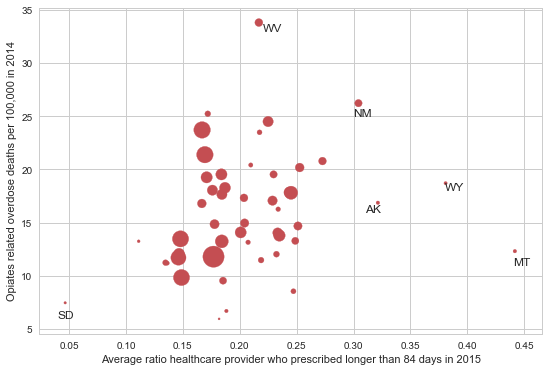

In [41]:
plt.figure(figsize=(9, 6))
s = .1 * overdose['Deaths'] 
plt.scatter(y=overdose['death_per_cap'], x=overdose['ratio_of_longer'], 
           s = s , 
            c = 'r')
plt.text(0.04, 6, 'SD')
plt.text(.44, 11, 'MT')
plt.text(.22, 33, 'WV')
plt.text(0.30, 25, 'NM')
plt.text(0.38, 18, 'WY')
plt.text(0.31, 16, 'AK')
plt.xlabel('Average ratio healthcare provider who prescribed longer than 84 days in 2015')
plt.ylabel('Opiates related overdose deaths per 100,000 in 2014')
#plt.savefig('assets/overdose_vs_ratio.png')
plt.show()

# Specialty vs opioids

In [42]:
cols_to_keep = ['specialty', 'op_longer'] + op_names
small = eda_df.loc[:, cols_to_keep]
small = small.loc[:, (small != 0).any(axis=0)]
small.shape

(17703, 20)

In [43]:
#freq_specialty = list(small.specialty.value_counts(ascending=False).index[:25])
small = small.loc[small['specialty'].isin(top40), :]
grouped = small.groupby('specialty').corrwith(small['op_longer'])
grouped = grouped.dropna(how='all', axis=1)
grouped = grouped.drop('op_longer', 1)

In [44]:
grouped

,acetaminophen_with_codeine,buprenorphine,buprenorphine_hcl,butorphanol_tartrate,dhcodeine_bt_acetaminophn_caff,fentanyl,hydrocodone_acetaminophen,hydrocodone_ibuprofen,hydromorphone_hcl,methadone_hcl,morphine_sulfate,morphine_sulfate_naltrexone,oxycodone_hcl,oxycodone_hcl_acetaminophen,oxymorphone_hcl,tapentadol_hcl,tramadol_hcl,tramadol_hcl_acetaminophen
specialty,,,,,,,,,,,,,,,,,,
allergy_immunology,NaN,NaN,NaN,NaN,NaN,NaN,0.568796,NaN,NaN,NaN,0.568796,NaN,0.809374,0.568796,NaN,NaN,0.568796,NaN
anesthesiology,0.233212,0.051053,NaN,NaN,0.077022,0.415055,0.595353,NaN,0.309131,0.358642,0.479118,NaN,0.402695,0.451827,0.119567,0.131093,0.438578,0.128609
cardiac_surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cardiology,0.285226,NaN,NaN,NaN,NaN,-0.016815,0.384220,0.166116,NaN,NaN,0.166116,NaN,0.235075,0.404551,NaN,NaN,0.574549,NaN
certified_clinical_nurse_specialist,0.552771,NaN,NaN,NaN,NaN,0.552771,0.793612,NaN,NaN,NaN,NaN,NaN,NaN,0.552771,NaN,NaN,0.772893,NaN
colorectal_surgery_(formerly_proctology),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
critical_care_(intensivists),NaN,NaN,NaN,NaN,NaN,NaN,-0.096010,NaN,NaN,NaN,NaN,NaN,-0.080845,0.512611,NaN,NaN,-0.080845,NaN
diagnostic_radiology,0.684653,NaN,NaN,NaN,NaN,NaN,0.937676,NaN,0.684653,0.684653,0.684653,NaN,0.680172,-0.120402,0.684653,NaN,0.672799,NaN
family_practice,0.149481,0.023812,NaN,NaN,NaN,0.169358,0.645230,-0.036782,0.063885,0.077791,0.141497,NaN,0.271330,0.363288,NaN,NaN,0.474752,0.091133


In [45]:
grouped.mean(axis=0).sort_values(ascending=False)

hydrocodone_acetaminophen         0.530958
oxycodone_hcl_acetaminophen       0.393568
buprenorphine_hcl                 0.384482
tramadol_hcl                      0.371607
morphine_sulfate                  0.329085
oxycodone_hcl                     0.319347
fentanyl                          0.270552
methadone_hcl                     0.231952
oxymorphone_hcl                   0.199150
acetaminophen_with_codeine        0.197754
hydromorphone_hcl                 0.187464
tapentadol_hcl                    0.088624
butorphanol_tartrate              0.084832
morphine_sulfate_naltrexone       0.082632
buprenorphine                     0.082266
hydrocodone_ibuprofen             0.061714
dhcodeine_bt_acetaminophn_caff    0.047339
tramadol_hcl_acetaminophen        0.026578
dtype: float64

In [46]:
grouped.mean(axis=1).sort_values(ascending=False)

specialty
certified_clinical_nurse_specialist                               0.644964
diagnostic_radiology                                              0.621501
allergy_immunology                                                0.616912
sports_medicine                                                   0.562651
pediatric_medicine                                                0.532361
infectious_disease                                                0.419102
pulmonary_disease                                                 0.408360
neurosurgery                                                      0.380642
orthopaedic_surgery                                               0.378103
gastroenterology                                                  0.325862
anesthesiology                                                    0.299354
physical_medicine_and_rehabilitation                              0.298245
osteopathic_manipulative_medicine                                 0.297619
interventional_

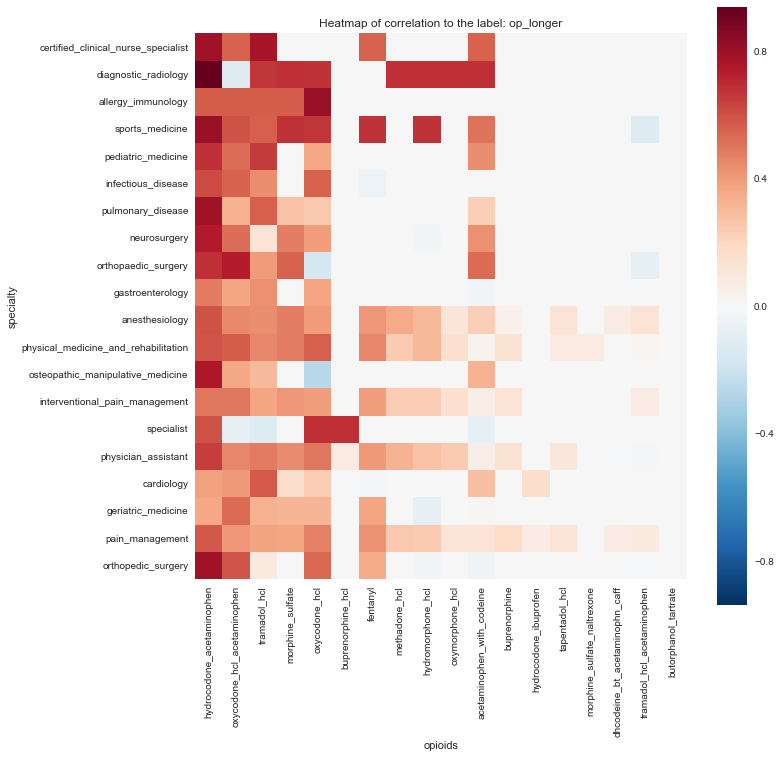

In [63]:
plt.figure(figsize=(11, 11))
sorted_op = grouped.mean(axis=0).sort_values(ascending=False).index
sorted_spec = grouped.mean(axis=1).sort_values(ascending=False).index[:20]
grouped = grouped.loc[sorted_spec, :]
grouped = grouped.loc[:, sorted_op]
g = sns.heatmap(grouped.fillna(0), square=True)
#plt.savefig('assets/clustermap_specialty_vs_op.png', orientation='landscape', dpi=199)
plt.title('Heatmap of correlation to the label: op_longer')
plt.ylabel('specialty')
plt.xlabel('opioids')
plt.show()

# Non-opioid vs Op_longer

#### Antibiotics

In [48]:
drug_name_dict.keys()

dict_keys(['Antibiotic Drug Flag', 'High Risk Medication (HRM) Drug Flag', 'others', 'Opioid Drug Flag', 'Antipsychotic Drug Flag'])

In [49]:
antibiotic_names = drug_name_dict['Antibiotic Drug Flag'] + ['op_longer', 'specialty']
antibiotic = eda_df.loc[:, antibiotic_names]
antibiotic = antibiotic.loc[antibiotic['specialty'].isin(top20), :]
antibiotic_corr = antibiotic.groupby('specialty').corrwith(antibiotic['op_longer'])
antibiotic_corr = antibiotic_corr.dropna(how='all', axis=1)
antibiotic_corr = antibiotic_corr.drop('op_longer', 1)

In [50]:
antibiotic_corr

,amoxicillin,amoxicillin_potassium_clav,ampicillin_trihydrate,azithromycin,cefaclor,cefadroxil,cefazolin_sodium,cefdinir,cefepime_hcl,cefpodoxime_proxetil,cefprozil,ceftriaxone_na_dextrose_iso,ceftriaxone_sodium,cefuroxime_axetil,cephalexin,ciprofloxacin_hcl,ciprofloxacin_lactate_d5w,clarithromycin,clindamycin_hcl,clindamycin_phosphate,dicloxacillin_sodium,doxycycline_hyclate,doxycycline_monohydrate,ertapenem_sodium,erythromycin_base,erythromycin_ethylsuccinate,fosfomycin_tromethamine,gentamicin_sulfate,levofloxacin,levofloxacin_d5w,meropenem,metronidazole,minocycline_hcl,moxifloxacin_hcl,neomycin_sulfate,nitrofurantoin_macrocrystal,nitrofurantoin_monohyd_m_cryst,ofloxacin,penicillin_g_benzathine,penicillin_v_potassium,piperacillin_tazo_dextrose_iso,rifaximin,sulfamethoxazole_trimethoprim,trimethoprim,vancomycin_hcl
specialty,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
anesthesiology,0.077022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.172168,0.077022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.077022,NaN,NaN
family_practice,0.179374,0.093466,0.036787,0.170698,0.023812,0.010717,NaN,0.067791,0.023812,0.028481,0.024826,0.023812,0.061783,0.114432,0.144240,0.219593,0.023812,0.047319,0.032786,0.023812,0.023812,0.119218,0.024977,0.023812,0.022787,-0.016859,-0.016859,0.044323,0.160741,0.023812,NaN,0.106029,0.027564,0.002990,NaN,0.047153,0.106898,-0.005323,NaN,-0.016346,0.023812,NaN,0.206266,0.027883,0.046626
general_practice,0.252581,0.136671,0.104010,0.212099,-0.062839,-0.062839,NaN,0.077984,NaN,NaN,0.002104,NaN,0.178123,0.094450,0.160952,0.264632,NaN,0.095904,-0.039712,NaN,NaN,0.129782,-0.039333,NaN,NaN,NaN,NaN,-0.038059,0.183776,NaN,NaN,0.069705,-0.086646,-0.062839,NaN,NaN,0.181409,-0.062839,0.10401,NaN,NaN,NaN,0.290787,NaN,NaN
geriatric_medicine,0.078052,0.016893,NaN,0.148640,NaN,NaN,NaN,-0.087117,NaN,NaN,NaN,NaN,0.160436,-0.079082,0.125120,0.281612,NaN,NaN,-0.087117,NaN,NaN,0.217545,0.204980,-0.087117,-0.087117,NaN,NaN,0.204980,0.224948,NaN,NaN,0.133672,NaN,-0.032623,NaN,-0.087117,-0.021269,NaN,NaN,NaN,NaN,NaN,0.157467,NaN,-0.029152
hematology_oncology,-0.051934,-0.015913,NaN,0.037858,NaN,NaN,NaN,NaN,NaN,NaN,0.098517,NaN,NaN,0.042525,0.032201,-0.018580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.042321,NaN,NaN,0.098517,NaN,-0.041095,NaN,NaN,0.098517,NaN,NaN,NaN,NaN,NaN,-0.013173,NaN,NaN
infectious_disease,0.096568,-0.134809,NaN,-0.092267,NaN,-0.057639,-0.057639,0.354068,-0.057639,-0.057639,NaN,NaN,-0.080031,-0.057639,-0.177360,-0.081851,NaN,-0.057639,-0.068600,NaN,NaN,-0.220256,0.226444,-0.097698,NaN,NaN,NaN,-0.057639,-0.169243,NaN,-0.057639,0.171239,-0.057639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.386503,NaN,-0.265100
internal_medicine,0.303450,0.250883,0.079154,0.345184,NaN,0.045545,NaN,0.067914,-0.011945,-0.034875,0.040655,NaN,0.059255,0.135487,0.269021,0.339889,NaN,0.065628,0.125622,0.030025,-0.011945,0.160307,0.053326,0.010380,-0.020302,NaN,-0.010103,0.061787,0.182820,-0.011945,-0.011945,0.174121,0.017404,0.012306,NaN,0.034824,0.188553,0.018934,NaN,0.069013,NaN,-0.020208,0.275602,NaN,-0.019477
interventional_pain_management,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.177535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
medical_oncology,-0.050373,0.177844,NaN,0.414238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.050362,-0.070772,NaN,NaN,NaN,-0.050373,NaN,-0.050373,NaN,NaN,NaN,NaN,NaN,NaN,-0.026606,NaN,NaN,NaN,0.206793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.287744,NaN,NaN


In [107]:
antibiotic_corr.mean(axis=0).sort_values(ascending=False)

ceftaroline_fosamil_acetate       0.189766
tigecycline                       0.189766
azithromycin                      0.184421
cefdinir                          0.137364
amoxicillin                       0.125428
sulfamethoxazole_trimethoprim     0.124425
cefuroxime_axetil                 0.100669
amoxicillin_potassium_clav        0.099139
ceftriaxone_sodium                0.098418
metronidazole                     0.082626
clindamycin_hcl                   0.082524
vancomycin_hcl                    0.082094
nitrofurantoin_monohyd_m_cryst    0.074261
ciprofloxacin_hcl                 0.070394
levofloxacin                      0.061886
ampicillin_trihydrate             0.056736
doxycycline_hyclate               0.051589
ertapenem_sodium                  0.043841
cephalexin                        0.043197
nitrofurantoin_macrocrystal       0.032058
clarithromycin                    0.027823
cefixime                          0.027352
ofloxacin                         0.021818
trimethopri

#### Antipsychotic


In [51]:
antipsy_names = drug_name_dict['Antipsychotic Drug Flag'] + ['op_longer', 'specialty']
antipsy = eda_df.loc[:, antipsy_names]
antipsy = antipsy.loc[antipsy['specialty'].isin(top20), :]
antipsy_corr = antipsy.groupby('specialty').corrwith(antipsy['op_longer'])
antipsy_corr = antipsy_corr.dropna(how='all', axis=1)
antipsy_corr = antipsy_corr.drop('op_longer', 1)

In [52]:
antipsy_corr

,aripiprazole,asenapine_maleate,chlorpromazine_hcl,clozapine,fluphenazine_hcl,haloperidol,haloperidol_decanoate,haloperidol_lactate,iloperidone,lurasidone_hcl,olanzapine,paliperidone,paliperidone_palmitate,perphenazine,quetiapine_fumarate,risperidone,risperidone_microspheres,thioridazine_hcl,trifluoperazine_hcl,ziprasidone_hcl,ziprasidone_mesylate
specialty,,,,,,,,,,,,,,,,,,,,,
anesthesiology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
family_practice,0.055995,NaN,NaN,NaN,NaN,0.056505,NaN,0.023812,0.023812,0.008281,0.058584,NaN,0.033677,0.023812,0.146884,0.092374,NaN,NaN,NaN,0.041008,0.023812
general_practice,0.077899,NaN,0.104010,NaN,NaN,0.147568,NaN,0.104010,NaN,NaN,0.099008,NaN,NaN,NaN,0.083479,0.036769,NaN,NaN,0.10401,NaN,NaN
geriatric_medicine,-0.087117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.129780,NaN,NaN,NaN,0.155090,0.199743,NaN,NaN,NaN,NaN,NaN
hematology_oncology,NaN,NaN,NaN,NaN,NaN,-0.041095,NaN,NaN,NaN,NaN,0.098517,NaN,NaN,NaN,-0.041095,-0.041095,NaN,NaN,NaN,NaN,NaN
infectious_disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.057639,-0.057639,NaN,NaN,NaN,NaN,NaN
internal_medicine,0.035944,NaN,-0.016729,-0.003048,NaN,0.010896,-0.011945,-0.017286,NaN,0.034448,0.063585,NaN,0.024702,NaN,0.219833,0.111140,-0.011945,NaN,NaN,0.034708,NaN
interventional_pain_management,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
medical_oncology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
others_names = drug_name_dict['others'] + ['op_longer', 'specialty']
others = eda_df.loc[:, others_names]
others = others.dropna(axis=1)

others = others.loc[others['specialty'].isin(top40), :]
others_corr = others.groupby('specialty').corrwith(others['op_longer'])
others_corr = others_corr.dropna(how='all', axis=1)
others_corr = others_corr.drop('op_longer', 1)

In [54]:
others_corr.mean(axis=0).sort_values(ascending=False)

gabapentin                        0.409202
omeprazole                        0.368022
metformin_hcl                     0.357480
alprazolam                        0.318405
furosemide                        0.315227
levothyroxine_sodium              0.307131
hydrochlorothiazide               0.304344
tamsulosin_hcl                    0.302572
meloxicam                         0.299456
amlodipine_besylate               0.287176
lisinopril                        0.284413
pregabalin                        0.282526
diazepam                          0.277529
potassium_chloride                0.271198
carvedilol                        0.270035
glimepiride                       0.267902
metoprolol_tartrate               0.266462
lorazepam                         0.264460
ibuprofen                         0.262256
atorvastatin_calcium              0.262010
atenolol                          0.259558
albuterol_sulfate                 0.258481
pravastatin_sodium                0.258392
clopidogrel

In [55]:
others_small = others_corr.dropna(thresh=len(others_corr) - 15, axis=1)
sorted_name = others_small.mean(axis=0).sort_values(ascending=False).index
sorted_spec = others_small.mean(axis=1).sort_values(ascending=False).index
others_small = others_small.loc[sorted_spec, :]
others_small = others_small.loc[:, sorted_name]

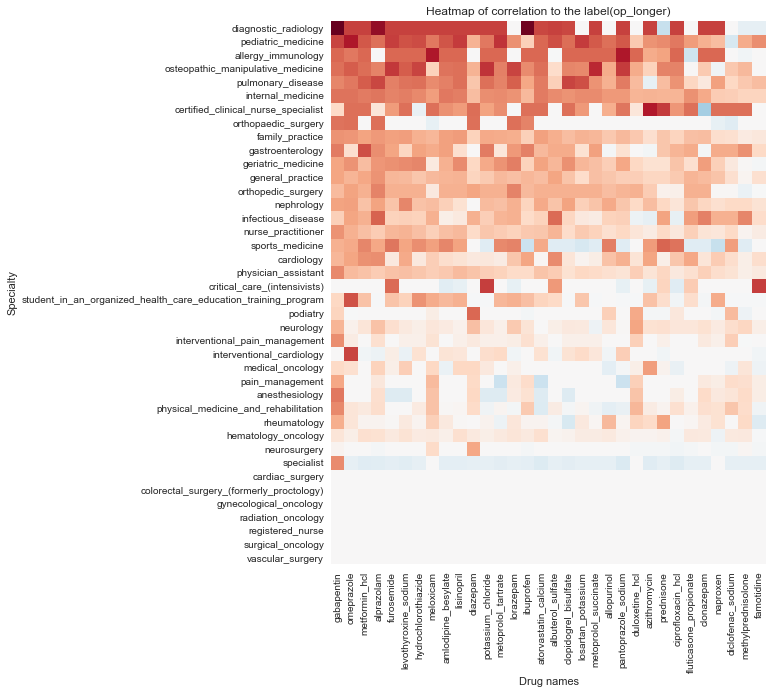

In [56]:
plt.figure(figsize=(10, 10))
sns.heatmap(others_small.fillna(0), square=True, cbar=False)
plt.title('Heatmap of correlation to the label(op_longer)')
plt.xlabel('Drug names')
plt.ylabel('Specialty')
plt.show()